In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
# filter warnings
warnings.filterwarnings('ignore')
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))


(-0.5, 63.5, 63.5, -0.5)

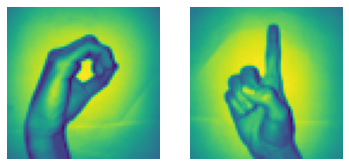

In [8]:
# load data set
x_l = np.load('./input/X.npy') # 2062 x 64 x 64
Y_l = np.load('input/Y.npy') # 2062 x 10
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(x_l[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_l[900])
plt.axis('off')

In [4]:
x_l[230].shape

(64, 64)

In [14]:
# Join a sequence of arrays along an row axis.
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) # from 0 to 204 is zero sign and from 205 to 410 is one sign 
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (410, 64, 64)
Y shape:  (410, 1)


In [15]:
# Then lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]
print('number_of_train: {} \nnumber_of_test: {}'.format(number_of_train,number_of_test))

number_of_train: 348 
number_of_test: 62


In [17]:
X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

X train flatten (348, 4096)
X test flatten (62, 4096)


In [18]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (4096, 348)
x test:  (4096, 62)
y train:  (1, 348)
y test:  (1, 62)


In [19]:
# short description and example of definition (def)
def dummy(parameter):
    dummy_parameter = parameter + 5
    return dummy_parameter
result = dummy(3)     # result = 8

# lets initialize parameters
# So what we need is dimension 4096 that is number of pixels as a parameter for our initialize method(def)
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b
w,b = initialize_weights_and_bias(4096)
print(w.shape)

(4096, 1)


In [20]:
# calculation of z
#z = np.dot(w.T,x_train)+b
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

In [21]:
y_head = sigmoid(0)
y_head

0.5

In [22]:
# Forward propagation steps:
# find z = w.T*x+b
# y_head = sigmoid(z)
# loss(error) = loss(y,y_head)
# cost = sum(loss)
def forward_propagation(w,b,x_train,y_train):
    z = np.dot(w.T,x_train) + b # (1 x 348)
    y_head = sigmoid(z) # probabilistic 0-1
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head) #cross entropy(binary)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    return cost 

In [23]:
# In backward propagation we will use y_head that found in forward progation
# Therefore instead of writing backward propagation method, 
#lets combine forward propagation and backward propagation
def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

In [24]:
# Updating(learning) parameters
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    # updating(learning) parameters is number_of_iterarion times
    for i in range(number_of_iterarion):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        # lets update
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list
#parameters, gradients, cost_list = update(w, b, x_train, y_train, 
#learning_rate = 0.009,number_of_iterarion = 200)

In [25]:
# prediction
def predict(w,b,x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction
# predict(parameters["weight"],parameters["bias"],x_test)

Cost after iteration 0: 14.014222
Cost after iteration 10: 2.544689
Cost after iteration 20: 2.577950
Cost after iteration 30: 2.397999
Cost after iteration 40: 2.185019
Cost after iteration 50: 1.968348
Cost after iteration 60: 1.754195
Cost after iteration 70: 1.535079
Cost after iteration 80: 1.297567
Cost after iteration 90: 1.031919
Cost after iteration 100: 0.737019
Cost after iteration 110: 0.441355
Cost after iteration 120: 0.252278
Cost after iteration 130: 0.205168
Cost after iteration 140: 0.196168


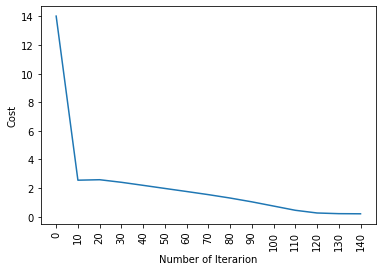

train accuracy: 92.816091954023 %
test accuracy: 93.54838709677419 %


In [26]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialize
    dimension =  x_train.shape[0]  # that is 4096
    w,b = initialize_weights_and_bias(dimension)
    # do not change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 150)

In [27]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(random_state = 42,max_iter= 150)
print("test accuracy: {} ".format(logreg.fit(x_train.T, y_train.T).score(x_test.T, y_test.T)))
print("train accuracy: {} ".format(logreg.fit(x_train.T, y_train.T).score(x_train.T, y_train.T)))

test accuracy: 0.967741935483871 
train accuracy: 1.0 


In [30]:
?linear_model.LogisticRegression

In [79]:
x_train.shape

(4096, 348)

In [48]:
y_train.shape

(1, 348)

In [49]:
# intialize parameters and layer sizes
def initialize_parameters_and_layer_sizes_NN(x_train, y_train):
    parameters = {"weight1": np.random.randn(3,x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((3,1)),
                  "weight2": np.random.randn(y_train.shape[0],3) * 0.1,
                  "bias2": np.zeros((y_train.shape[0],1))}
    return parameters

In [50]:
def forward_propagation_NN(x_train, parameters):

    Z1 = np.dot(parameters["weight1"],x_train) +parameters["bias1"] 
    A1 = np.tanh(Z1)                 # 3 x 4096 dot 4096 x 348 =3 x 348 shape
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"] 
    A2 = sigmoid(Z2)           # 1 x 3 dot 3 x 348 =1 x 348 > y와 똑같은 shape > 확인

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [56]:
# Compute cost
def compute_cost_NN(A2, Y, parameters):
    #logprobs = np.multiply(np.log(A2),Y) # ? (~) x (0,1,0,1,1,1~)
    logprobs =  np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),1-Y) # ??
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

In [57]:
# Backward Propagation
def backward_propagation_NN(parameters, cache, X, Y):

    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

In [58]:
# update parameters
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"]-learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"]-learning_rate*grads["dbias2"]}
    
    return parameters

In [59]:
# prediction
def predict_NN(parameters,x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test,parameters)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(A2.shape[1]):
        if A2[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Cost after iteration 0: 0.692227
Cost after iteration 100: 0.670942
Cost after iteration 200: 0.617286
Cost after iteration 300: 0.522611
Cost after iteration 400: 0.420499
Cost after iteration 500: 0.335695
Cost after iteration 600: 0.271692
Cost after iteration 700: 0.224656
Cost after iteration 800: 0.189833
Cost after iteration 900: 0.163244
Cost after iteration 1000: 0.142166
Cost after iteration 1100: 0.124920
Cost after iteration 1200: 0.110582
Cost after iteration 1300: 0.098648
Cost after iteration 1400: 0.088711
Cost after iteration 1500: 0.080383
Cost after iteration 1600: 0.073334
Cost after iteration 1700: 0.067301
Cost after iteration 1800: 0.062087
Cost after iteration 1900: 0.057541
Cost after iteration 2000: 0.053551
Cost after iteration 2100: 0.050028
Cost after iteration 2200: 0.046899
Cost after iteration 2300: 0.044103
Cost after iteration 2400: 0.041588


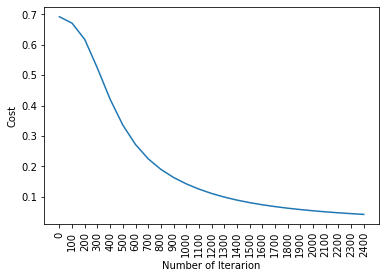

train accuracy: 99.71264367816092 %
test accuracy: 93.54838709677419 %


In [60]:
# 2 - Layer neural network
def two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations):
    cost_list = []
    index_list = []
    #initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)

    for i in range(0, num_iterations):
         # forward propagation
        A2, cache = forward_propagation_NN(x_train,parameters)
        # compute cost
        cost = compute_cost_NN(A2, y_train, parameters)
         # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
         # update parameters
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 100 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    # predict
    y_prediction_test = predict_NN(parameters,x_test)
    y_prediction_train = predict_NN(parameters,x_train)
    
     # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters

parameters = two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations=2500)

In [61]:
# reshaping
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T

In [62]:
x_train.shape

(348, 4096)

In [63]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, epochs = 100)
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 3)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

Epoch 1/100
8/8 [==============================] - 17s 2ms/step - loss: 0.6930 - accuracy: 0.5076
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5660
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.5330
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5450
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5316
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4988
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.5570
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5201
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5280
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5295
Epoch 11/100
8/8 [==========

8/8 [==============================] - 0s 2ms/step - loss: 0.1933 - accuracy: 0.9463
Epoch 85/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.9739
Epoch 86/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1705 - accuracy: 0.9780
Epoch 87/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1678 - accuracy: 0.9739
Epoch 88/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1771 - accuracy: 0.9763
Epoch 89/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9775
Epoch 90/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.9758
Epoch 91/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.9640
Epoch 92/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1547 - accuracy: 0.9801
Epoch 93/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1540 - accuracy: 0.9720
Epoch 94/100
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.2811 - accuracy: 0.9863
Epoch 67/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2964 - accuracy: 0.9589
Epoch 68/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2869 - accuracy: 0.9717
Epoch 69/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2629 - accuracy: 0.9794
Epoch 70/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2828 - accuracy: 0.9702
Epoch 71/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.9748
Epoch 72/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.9713
Epoch 73/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2935 - accuracy: 0.9801
Epoch 74/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2750 - accuracy: 0.9614
Epoch 75/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2710 - accuracy: 0.9715
Epoch 76/100
8/8 [===============

8/8 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.9597
Epoch 49/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9674
Epoch 50/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9738
Epoch 51/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1129 - accuracy: 0.9400
Epoch 52/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0911 - accuracy: 0.9742
Epoch 53/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0993 - accuracy: 0.9559
Epoch 54/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0849 - accuracy: 0.9726
Epoch 55/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0752 - accuracy: 0.9870
Epoch 56/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9758
Epoch 57/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1029 - accuracy: 0.9680
Epoch 58/100
8/8 [===============

In [64]:
accuracies

array([0.98275864, 0.94827586, 0.90517241])